In [159]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from util.evaluation import SMAPE
%matplotlib inline

traffic=pd.read_csv('../data/cl_traffic.csv')

traffic=traffic.fillna(0)

traffic.head()

sample_index=np.random.choice(traffic.index,4000,replace=False)
sample_series=[]
for u in sample_index:
#     print('Training...|| {:.2f}'.format(u/tot_len*100)+'%',end='\r')
    sample_series.append(traffic.loc[u][:-4].values)

def diff(x,epsilon=1e-3):
    return((x[1:]-x[:-1])/(x[:-1]+epsilon))

# combs=np.array([[0,0,0]])
# for series in range(len(sample_series)):
#     change=diff(sample_series[series][1:-2])
#     comb=np.array([change[1:-2],change[2:-1],change[3:]]).T
#     combs=np.concatenate((combs,comb),axis=0)

## prepare training and testing data

In [160]:
def split_and_clean(sample_series,train_start,train_end,test_len):
    clean_series=[]
    test_series=[]
    for index in range(len(sample_series)):
        c=np.array(sample_series[index][train_start:train_end])
        test_series.append(sample_series[index][train_end:(train_end+test_len)])
        std=np.std(c)
        mean=np.mean(c)
        c[(c-np.mean(c))>2*std]=mean+2*std
        c[(c-np.mean(c))<-2*std]=mean-2*std
        clean_series.append(c)
    return (clean_series,test_series)

In [161]:
# plt.plot(clean_series[1])

In [162]:
def value2id(series,bin_size,biased_mean,std):
    id_series=np.array(list(map(lambda x:(x-biased_mean) // (std*bin_size),series)))
    id_series[id_series>(6/bin_size)]=(6/bin_size)
    id_series[id_series<0]=0
    return id_series

In [163]:
def id2value(id_series,bin_size,biased_mean,std):
    return id_series*(std*bin_size)+biased_mean

In [164]:
def discrify(clean_series):
    bin_size=0.005
    discrete_dic={}
    index_series=[]
    for i in range(len(clean_series)):
        if np.sum(clean_series[i])==0:
            std=-1
            biased_mean=-1
            discrete_dic[i]=(std,biased_mean)
            index_series.append(np.zeros_like(clean_series[i])+3/bin_size)
        else:
            std=np.std(clean_series[i])
            biased_mean=np.mean(clean_series[i])-3*std

            discrete_dic[i]=(std,biased_mean)
            index_series.append(value2id(clean_series[i],bin_size=bin_size,biased_mean=biased_mean,std=std))
    return (discrete_dic,index_series)

In [165]:
encode_start=0
encode_end=150
decode_len=63

clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)


train_x=clean_series
train_y=decode_series

encode_start=200
encode_end=350
decode_len=63


clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)

test_x=clean_series
test_y=decode_series

In [166]:
# for i in decode_series:
#     if sum(i[i>1199])>0:
#         print(i)

In [167]:
# changes=[]
# for series in range(len(sample_series)):
#     change=diff(sample_series[series][1:-2])
# #     change[change>2]=2
#     changes.append(change)

In [168]:
# changes=np.array(changes)

In [169]:
# changes.shape

In [170]:
# def num2index(num):
#     return int((num+1) // 0.0025)
# index
# def index2num(index):
#     return -1+(index+0.5)*0.0025

# index2num(1199)



In [171]:
# #discrete change
# dis_change=[]
# for i in range(len(changes)):
#     dis_change.append(list(map(lambda x:num2index(x),changes[i,:])))

In [172]:
# dis_change=np.array(dis_change)

In [173]:
# assert dis_change.shape==changes.shape

In [174]:
# train_x=dis_change[:,265:365]
# train_y=changes[:,365:365+63]
# test_x=dis_change[:,400:500]
# test_y=changes[:,500:500+63]

In [180]:
def X_loader(x,batchsize=10):
    batch=0
    x=np.array(x)
    while batch<(len(x) // batchsize):
        
        data=x[batch*batchsize:(batch+1)*batchsize,:]
        tensor=torch.FloatTensor(np.array(data, dtype=float))
        tensor=tensor.unsqueeze(2).cuda()
#         tensor=tensor.repeat(1,1,25)
        yield(tensor)
        batch+=1

In [181]:
def Y_loader(y,batchsize=10):
    batch=0
    y=np.array(y)
    while batch<(len(y) // batchsize):
        
        data=y[batch*batchsize:(batch+1)*batchsize,:]
        tensor=torch.FloatTensor(np.array(data, dtype=float))
        tensor=tensor.unsqueeze(2).cuda()

        yield(tensor)
        batch+=1

In [53]:
trainx=X_loader(train_x)
a=next(trainx)

In [ ]:
a.shape

In [ ]:
a.repeat(1,1,25).shape

In [108]:
import torch
import torch.nn as nn

class NN(nn.Module):
    def __init__(self, encoder_dim=150,out_dim=63):
        super(NN, self).__init__()

        self.encoder = nn.GRU(25, encoder_dim, batch_first=True, bidirectional=False)
        self.decoder = nn.Linear(encoder_dim, out_dim)
    def forward(self, x):
            
#         print('embedding',out)
        output, hidden = self.encoder(x)
#         print('hidden',hidden)
        output = self.decoder(hidden)
        return output.squeeze()

In [104]:
model=NN(encoder_dim=25,out_dim=10).cuda()

In [50]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print (name, param.data)

In [177]:
def SMAPE(true,predicted):
    true=true.squeeze()
    predicted=predicted.squeeze()
    epsilon = 0.1
    summ = torch.abs(true) + torch.abs(predicted) + epsilon
    smape = torch.abs(predicted - true) / summ * 2.0
    return torch.mean(smape)

In [113]:
from torch import optim
epoch=30
indicator=200

model=NN(encoder_dim=25,out_dim=10).cuda()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, \
    eps=1e-08, weight_decay=0, momentum=0, centered=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)

for i in range(epoch):
    trainx=X_loader(train_x)
    trainy=Y_loader(train_y)
    running_loss = 0.0
    validation(test_x,test_y)
    for j,X_batch in enumerate(trainx):
        #Parse loaded batch
        
        model.train()

        optimizer.zero_grad()
        output = model(X_batch)
        

        target=next(trainy)
        loss = SMAPE(target,output)

        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        optimizer.step()

        running_loss += loss.item()

        if (j>0) and (j % indicator == 0):
            print("Epoch: {}; iterations: {}; Loss: {}\n".format(i, j, running_loss / indicator))
            running_loss = 0.0
#             for name, param in model.named_parameters():
#                 if param.requires_grad:
#                     print (name, param.data,param.grad.data)
#             print(output)


VALIDATION: Epoch: 0; Loss: 1.8928367682321818

Epoch: 0; iterations: 200; Loss: 1.5732004761695861

Epoch: 0; iterations: 400; Loss: 1.4581313353776932

Epoch: 0; iterations: 600; Loss: 1.4049494770169257

Epoch: 0; iterations: 800; Loss: 1.375493532717228

Epoch: 0; iterations: 1000; Loss: 1.3471135514974595

Epoch: 0; iterations: 1200; Loss: 1.283590589761734

Epoch: 0; iterations: 1400; Loss: 1.2652345237135887

Epoch: 0; iterations: 1600; Loss: 1.2642853540182113

Epoch: 0; iterations: 1800; Loss: 1.2649759605526925

Epoch: 0; iterations: 2000; Loss: 1.235699926018715

Epoch: 0; iterations: 2200; Loss: 1.2327824780344963

Epoch: 0; iterations: 2400; Loss: 1.2218928948044776

Epoch: 0; iterations: 2600; Loss: 1.2157596817612648

Epoch: 0; iterations: 2800; Loss: 1.1965202409029008

Epoch: 0; iterations: 3000; Loss: 1.1973932653665542

Epoch: 0; iterations: 3200; Loss: 1.1793283292651175

Epoch: 0; iterations: 3400; Loss: 1.17320089712739

Epoch: 0; iterations: 3600; Loss: 1.1658834

Epoch: 2; iterations: 2600; Loss: 0.9585588216781616

Epoch: 2; iterations: 2800; Loss: 0.9605448086559772

Epoch: 2; iterations: 3000; Loss: 0.9662077829241753

Epoch: 2; iterations: 3200; Loss: 0.9502517284452915

Epoch: 2; iterations: 3400; Loss: 0.9570618136227131

Epoch: 2; iterations: 3600; Loss: 0.9396382448077202

Epoch: 2; iterations: 3800; Loss: 0.9480431990325451

Epoch: 2; iterations: 4000; Loss: 0.9209232300519943

Epoch: 2; iterations: 4200; Loss: 0.9230095812678337

Epoch: 2; iterations: 4400; Loss: 0.9237991730868816

Epoch: 2; iterations: 4600; Loss: 0.9621127474308014

Epoch: 2; iterations: 4800; Loss: 0.9462943284213543

Epoch: 2; iterations: 5000; Loss: 0.9456500299274921

Epoch: 2; iterations: 5200; Loss: 0.9700519758462905

Epoch: 2; iterations: 5400; Loss: 0.9598549999296665

Epoch: 2; iterations: 5600; Loss: 0.9326630933582782

Epoch: 2; iterations: 5800; Loss: 0.9304283303022385

Epoch: 2; iterations: 6000; Loss: 0.9531055231392384

Epoch: 2; iterations: 6200; 

Epoch: 4; iterations: 5000; Loss: 1.013347352743149

Epoch: 4; iterations: 5200; Loss: 1.0114017915725708

Epoch: 4; iterations: 5400; Loss: 1.0223344850540161

Epoch: 4; iterations: 5600; Loss: 1.0096289375424385

Epoch: 4; iterations: 5800; Loss: 1.015274694263935

Epoch: 4; iterations: 6000; Loss: 1.0140830989181995

Epoch: 4; iterations: 6200; Loss: 0.9838367629051209

Epoch: 4; iterations: 6400; Loss: 1.0415766434371472

Epoch: 4; iterations: 6600; Loss: 1.003930580317974

Epoch: 4; iterations: 6800; Loss: 0.9961859285831451

Epoch: 4; iterations: 7000; Loss: 1.0294593527913094

Epoch: 4; iterations: 7200; Loss: 0.9893988013267517

Epoch: 4; iterations: 7400; Loss: 0.9516907209157943

Epoch: 4; iterations: 7600; Loss: 0.9878515726327897

Epoch: 4; iterations: 7800; Loss: 0.9681191071867943

Epoch: 4; iterations: 8000; Loss: 0.998572615981102

Epoch: 4; iterations: 8200; Loss: 1.0085950012505054

Epoch: 4; iterations: 8400; Loss: 0.9677828377485276

Epoch: 4; iterations: 8600; Loss

Epoch: 6; iterations: 7400; Loss: 0.9089007914066315

Epoch: 6; iterations: 7600; Loss: 0.9468275462090969

Epoch: 6; iterations: 7800; Loss: 0.9277120563387871

Epoch: 6; iterations: 8000; Loss: 0.9532852186262608

Epoch: 6; iterations: 8200; Loss: 0.9477252152562141

Epoch: 6; iterations: 8400; Loss: 0.9365708765387535

Epoch: 6; iterations: 8600; Loss: 0.9097199508547783

Epoch: 6; iterations: 8800; Loss: 0.9848549573123455

Epoch: 6; iterations: 9000; Loss: 1.0076705695688724

Epoch: 6; iterations: 9200; Loss: 1.0101263949275017



KeyboardInterrupt: 

In [15]:
def validation(test_x,test_y):
    testx=X_loader(test_x)
    testy=Y_loader(test_y)
    running_loss = 0.0
    for j,X_batch in enumerate(testx):
        #Parse loaded batch
        
        model.eval()
        output = model(X_batch)
#         MSE = nn.MSELoss()
        target=next(testy)
        loss = SMAPE(target,output)
        running_loss += loss.item()
        print(j,end='\r')
        if j >500:
            break
    print("VALIDATION: Epoch: {}; Loss: {}\n".format(i, running_loss / j))


In [92]:
testx=X_loader(test_x)
testy=Y_loader(test_y)
running_loss = 0.0

preds=[]
targets=[]

scores=[]
for j,X_batch in enumerate(testx):
    #Parse loaded batch

    model.eval()
    output = model(X_batch)

    target=next(testy)
    loss = SMAPE(target,output)
    scores.append(loss.item())
    out=output.detach().cpu().numpy()
    target=target.detach().cpu().numpy()
    if j ==0:
        preds=out
        targets=target
    else:
        preds=np.concatenate((preds,out),axis=0)
        targets=np.concatenate((targets,target),axis=0)

In [93]:
testy=Y_loader(test_y)

In [71]:
b=next(testy)

In [72]:
b.shape

torch.Size([10, 10])

In [74]:
# b

In [26]:
testx=X_loader(test_x)

In [38]:
a=next(testx)

In [81]:
model(a*0.1)

tensor([[  0.8660,   0.7198,   0.7961,   0.8807,   0.8273,   0.8657,
           0.8306,   0.8440,   0.7945,   0.7082],
        [ -0.0646,  -0.0918,  -0.0662,  -0.0747,  -0.0824,  -0.0652,
          -0.0787,  -0.0708,  -0.0672,  -0.0752],
        [  0.4423,   0.3598,   0.4255,   0.4583,   0.4231,   0.4540,
           0.4242,   0.4292,   0.4064,   0.3821],
        [ 25.6526,  25.4014,  25.0006,  27.6423,  26.9459,  26.2854,
          26.3887,  25.8179,  24.7527,  25.2589],
        [  8.6509,   8.2487,   8.3812,   9.2030,   8.9090,   8.8745,
           8.7344,   8.6792,   8.1685,   8.3825],
        [  0.0067,   0.0032,   0.0078,   0.0039,   0.0059,   0.0076,
           0.0057,   0.0040,   0.0056,   0.0063],
        [ 23.2517,  22.8867,  22.4827,  25.0516,  24.3713,  23.8319,
          23.8098,  23.4247,  22.3898,  22.8923],
        [ 32.0793,  32.0578,  31.4899,  34.5718,  33.7392,  32.7997,
          33.1382,  32.2140,  31.0240,  31.5368],
        [  0.2126,   0.1493,   0.2083,   0.2149,

In [41]:
a.shape

torch.Size([10, 150, 25])

In [18]:
np.mean(scores)

1.4529695603251458

In [76]:
len(preds)

4000

In [77]:
# def recover(start,change):
#     series=[]
#     last=start
#     for c in change:
#         last=last*(1+c)
#         series.append(last)
#     return series

In [45]:
# def recover(ID,series,bin_size):
#     std,biased_mean=discrete_dic[ID]
#     series=series*(std*bin_size)+biased_mean
#     return series

In [94]:
preds

array([[61.72419  , 61.01527  , 60.17254  , ..., 61.448544 , 60.616264 ,
        60.525696 ],
       [61.72419  , 61.01527  , 60.17254  , ..., 61.448544 , 60.616264 ,
        60.525696 ],
       [59.257797 , 58.51191  , 57.55127  , ..., 58.932667 , 58.026352 ,
        57.92686  ],
       ...,
       [61.72419  , 61.01527  , 60.17254  , ..., 61.448544 , 60.616264 ,
        60.525696 ],
       [61.616505 , 60.906246 , 60.066288 , ..., 61.340267 , 60.508945 ,
        60.4181   ],
       [ 6.663654 ,  6.4042926,  5.8321004, ...,  6.886004 ,  6.293185 ,
         6.2729697]], dtype=float32)

[61.72419  61.01527  60.17254  64.43452  64.944595 62.347313 63.609066
 61.448544 60.616264 60.525696]


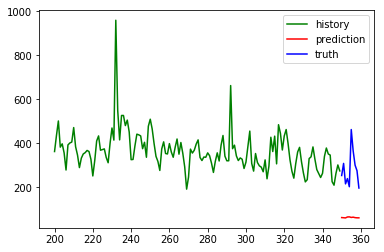

In [100]:
ID=200
source=sample_series[ID][encode_start:encode_end]
pred=preds[ID]
truth=targets[ID]
print(pred)
# for i in range(10):
plt.figure()
plt.plot(np.arange(encode_start,encode_end),source,color='g',label='history')
plt.plot(np.arange(encode_end,encode_end+decode_len),pred,color='r',label='prediction')
plt.plot(np.arange(encode_end,encode_end+decode_len),truth,color='b',label='truth')
plt.legend()

In [129]:
a=next(trainx)

In [132]:
a[:,2,:].shape

torch.Size([10, 25])

In [131]:
a.shape

torch.Size([10, 150, 25])

In [68]:
from util.evaluation import SMAPE
mean_scores=[]
for ID in range(4000):
    source=sample_series[ID][encode_start:encode_end]
    pred=preds[ID]
    truth=targets[ID]
    scores=[]
    for (t,p) in zip(truth,pred):
        scores.append(SMAPE(t,p))

    mean_scores.append(np.mean(scores))
np.mean(mean_scores)

1.2302703113622075

In [2]:
from torch import optim
epoch=30
indicator=20

# optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, \
#     eps=1e-08, weight_decay=0, momentum=0, centered=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)
hidden_size=10
lr=0.01


encoder=EncoderRNN(1,hidden_size).cuda() if use_cuda else EncoderRNN(1,hidden_size)
decoder=DecoderRNN(1,hidden_size).cuda() if use_cuda else DecoderRNN(1,hidden_size)
teacher_forcing_ratio = 1
encoder_optimizer = optim.SGD(encoder.parameters(), lr=lr)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=lr)

for i in range(epoch):
    trainx=X_loader(train_x)
    trainy=Y_loader(train_y)
    running_loss = 0.0
#     validation(test_x,test_y)
    for j,X_batch in enumerate(trainx):
        #Parse loaded batch
        
        x=next(trainx)
        y=next(trainy)
        loss=train(x, y, encoder, decoder, encoder_optimizer, \
                  decoder_optimizer, SMAPE)
        running_loss += loss

        if (j>0) and (j % indicator == 0):
            print("Epoch: {}; iterations: {}; Loss: {}\n".format(i, j, running_loss / indicator))
            running_loss = 0.0

NameError: name 'EncoderRNN' is not defined

In [187]:
trainx=X_loader(train_x)
trainy=Y_loader(train_y)


1.9928925529358879

In [185]:
from numpy import random as random

In [3]:
use_cuda=True
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.gru = nn.GRU(1, hidden_size)

    def forward(self, input, hidden):

        output, hidden = self.gru(input, hidden)
        return output, hidden

    def initHidden(self):
        result = torch.zeros(1, 1, self.hidden_size)
        if use_cuda:
            return result.cuda()
        else:
            return result

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(1, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)


    def forward(self, input, hidden):

        output, hidden = self.gru(input, hidden)

        return output, hidden

    def initHidden(self):
        result = torch.zeros(1, 1, self.hidden_size)
        if use_cuda:
            return result.cuda()
        else:
            return result




def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, \
          decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[1]
    target_length = target_variable.size()[1]
    
    encoder_outputs = torch.zeros(input_length, encoder.hidden_size)
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
   
    loss = 0

    for ei in range(input_length):

        encoder_output, encoder_hidden = encoder(
            input_variable[:,ei:(ei+1),:], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = input_variable[:,-1:,:]
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[:,di:di+1,:])
            decoder_input = target_variable[:,di:di+1,:]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):

            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            decoder_input = decoder_output
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            
            loss += criterion(decoder_output, target_variable[:,di:di+1,:])

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

NameError: name 'nn' is not defined